In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib as mpl
import os

from IPython.core.pylabtools import figsize
from scipy import stats

In [8]:
#Getting Working Directory
os.getcwd()

#Setting style and font size for graphs
sns.set_style("whitegrid")
mpl.rcParams['font.size'] = 13

In [9]:
#load original data into dataframe
file ='df_clean2.csv'
df_clean2 = pd.read_csv(file)
df_clean2.shape

(100110, 44)

In [10]:
# Converting IDs to Object class
ids = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id' ]

df_clean2[ids] = df_clean2[ids].astype('object')

In [11]:
#Encoding Age. To retain the ordinal nature of age 
age_dict = {'[70-80)': 75,'[80-90)': 85, '[90-100)':100, '[60-70)': 65, '[50-60)': 55, '[40-50)': 45, '[30-40)':35,
           '[20-30)': 25, '[10-20)': 15, '[0-10)': 5}
df_clean2.age = df_clean2.age.map(age_dict)

#Encoding Gender
gender_dict = {'Female': 0, 'Male': 1}
df_clean2.gender = df_clean2.gender.map(gender_dict)

#Visit_num Encoding as Number. '>3' was considered as 4 for simplification purposes
visit_num_dict = {'1.0': 1, '2.0': 2, '3.0': 3, '>3': 4}
df_clean2.visit_num = df_clean2.visit_num.map(visit_num_dict)

#Target Variable Encoding. 'NO' as Not Readmitted and '>30' and '<30' as Readmitted. 
#Converting 3 class problem to a binary classification
readmitted_dict = {'NO': 0, '>30': 1, '<30': 1}
df_clean2.readmitted = df_clean2.readmitted.map(readmitted_dict)


#Encoding Change
change_dict = {'No': 0, 'Ch': 1}
df_clean2.change = df_clean2.change.map(change_dict)

#Encoding diabetesMed
diab_dict = {'No': 0, 'Yes': 1}
df_clean2.diabetesMed = df_clean2.diabetesMed.map(diab_dict)


In [12]:
# Separating Numeric and Non_numeric Data
numeric = df_clean2.select_dtypes(exclude = 'object')
categorical = df_clean2.select_dtypes(include = 'object')

#Creating Dummy variables for Categorical Data using One Hot Encoding
dummies = pd.get_dummies(categorical,drop_first = True)

In [13]:
numeric.skew()

gender                 0.152517
age                   -0.527107
time_in_hospital       1.137940
num_lab_procedures    -0.241428
num_procedures         1.326183
num_medications        1.333150
number_outpatient      8.817966
number_emergency      22.841725
number_inpatient       3.626415
number_diagnoses      -0.867676
change                 0.144781
diabetesMed           -1.295661
readmitted             0.126234
visit_num              1.752839
dtype: float64

In [14]:
#Creating our Feature and Target Data Set: X, y respectively

X = pd.concat([numeric,dummies],axis=1).drop('readmitted', axis = 1)
y = df_clean2.readmitted

#Splitting Data into Training and Test Data Set
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


In [15]:
X_train.shape

(70077, 105)

There are two types of error, False Positive and False Negative. Predicting that a patient will not get readmitted but actually patient gets readmitted. This is false negative. Predicting that a patient will get readmitted but in actually he will not os called false positive. For an hospital, a false negative error is not desirable. They can still live with a false positive error. So in below models we will look at reducing false negative error. 

High Recall for class 'Readmitted', Better the model


Ensuring that we have the same fractions of all class in both train and test data set. Let's Calculate the fraction

### Logistic Regression

In [16]:
# Base Line Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support,log_loss
class_names = ['Not Readmitted', 'Readmitted']

In [17]:
def auc_curve(y_test,y_pred_test,auc_test):
    fpr,tpr, threshold = roc_curve(y_test, y_pred_test)
    _ = plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' %auc_test )
    _ = plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    _ = plt.xlim([0.0, 1.0])
    _ = plt.ylim([0.0, 1.05])
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Receiver operating characteristic example')
    _ = plt.legend(loc="lower right")


### Base Line Evaluation - L2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.2s finished


Training accuracy: 0.6289
Test accuracy    : 0.6280
Training AUC Score: 0.6732
Testing AUC Score: 0.6718
Classification Report - Training
              precision    recall  f1-score   support

           0       0.62      0.77      0.69     37271
           1       0.64      0.47      0.54     32806

    accuracy                           0.63     70077
   macro avg       0.63      0.62      0.61     70077
weighted avg       0.63      0.63      0.62     70077

Classification Report - Testing
                precision    recall  f1-score   support

Not Readmitted       0.62      0.77      0.69     15937
    Readmitted       0.64      0.47      0.54     14096

      accuracy                           0.63     30033
     macro avg       0.63      0.62      0.61     30033
  weighted avg       0.63      0.63      0.62     30033



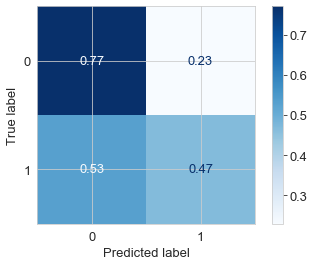

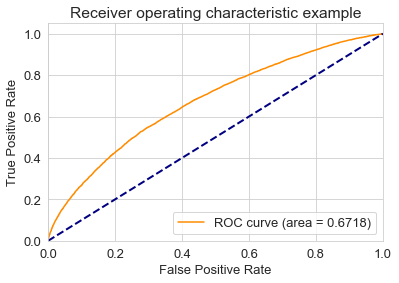

In [18]:
# Base Line Evaluation

#Building the Logistic Regression Model
lr = LogisticRegression(max_iter = 4000, verbose = 1)

lr.fit(X_train,y_train)

#Predicting for testing and trainig data sets
y_test_proba = lr.predict_proba(X_test)[:,1]
y_train_proba = lr.predict_proba(X_train)[:,1]

y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

#Accuracy Score
print("Training accuracy: %0.4f" %lr.score(X_train, y_train))
print("Test accuracy    : %0.4f" %lr.score(X_test, y_test))
#print("Test log loss    : %0.4f" %log_loss(y_train, lr.predict_proba(X_train)))
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(lr, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


In [13]:
coefficients = lr.coef_[0]
coef = pd.DataFrame(coefficients, index = X_train.columns, columns = ['Coefficient'])
coef.sort_values('Coefficient', inplace = True)
print("Top 5:")
print(coef[-5:] )

print("\nBottom 5:")
print(coef[:5])

Top 5:
                      Coefficient
number_inpatient         0.298875
rosiglitazone_Up         0.316629
rosiglitazone_No         0.366738
admission_type_id_4      0.472235
rosiglitazone_Steady     0.484066

Bottom 5:
                       Coefficient
admission_source_id_9    -0.831086
miglitol_No              -0.485145
diag_1_Neoplasms         -0.414863
chlorpropamide_No        -0.363985
race_Asian               -0.363858


### Base Line Evaluation  - L1

Training accuracy: 0.6288
Test accuracy    : 0.6283
Training AUC Score: 0.6732
Testing AUC Score: 0.6717
Classification Report - Training
              precision    recall  f1-score   support

           0       0.62      0.77      0.69     37271
           1       0.64      0.47      0.54     32806

    accuracy                           0.63     70077
   macro avg       0.63      0.62      0.61     70077
weighted avg       0.63      0.63      0.62     70077

Classification Report - Testing
                precision    recall  f1-score   support

Not Readmitted       0.62      0.77      0.69     15937
    Readmitted       0.64      0.47      0.54     14096

      accuracy                           0.63     30033
     macro avg       0.63      0.62      0.61     30033
  weighted avg       0.63      0.63      0.62     30033



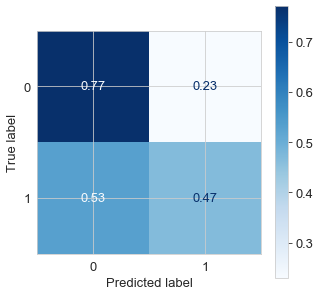

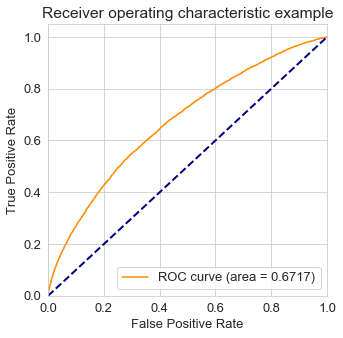

In [73]:
#Building the Logistic Regression Model
lr1 = LogisticRegression(penalty = 'l1', solver = 'liblinear', max_iter = 4000)

lr1.fit(X_train,y_train)

#Predicting for testing and trainig data sets
y_test_proba = lr1.predict_proba(X_test)[:,1]
y_train_proba = lr1.predict_proba(X_train)[:,1]

y_pred_test = lr1.predict(X_test)
y_pred_train = lr1.predict(X_train)

#Accuracy Score
print("Training accuracy: %0.4f" %lr1.score(X_train, y_train))
print("Test accuracy    : %0.4f" %lr1.score(X_test, y_test))
#print("Test log loss    : %0.4f" %log_loss(y_train, lr.predict_proba(X_train)))
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(lr1, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)

In [74]:
coefficients1 = lr1.coef_[0]
coef = pd.DataFrame(coefficients1, index = X_train.columns, columns = ['Coefficient'])
coef.sort_values('Coefficient', inplace = True)
print("Zero Coefficient Features")
print(coef[coef.Coefficient == 0])

#print("\nBottom 5:")
#print(coef[:6])

Zero Coefficient Features
                                 Coefficient
acetohexamide_Steady                     0.0
tolazamide_Up                            0.0
glyburide-metformin_Steady               0.0
troglitazone_Steady                      0.0
miglitol_Up                              0.0
glipizide-metformin_Steady               0.0
glimepiride-pioglitazone_Steady          0.0
miglitol_Steady                          0.0
acarbose_Up                              0.0
glyburide_No                             0.0
acarbose_Steady                          0.0
metformin-pioglitazone_Steady            0.0
repaglinide_Steady                       0.0
metformin-rosiglitazone_Steady           0.0


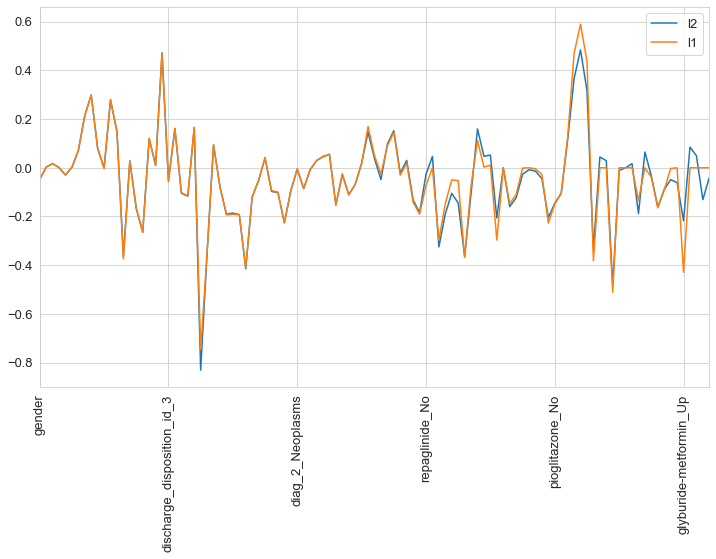

In [75]:
figsize(12,7)
main = np.concatenate((lr.coef_,lr1.coef_), axis =0).T
coef = pd.DataFrame(main, index = X_train.columns, columns = ['l2','l1'])
_ = coef.plot()
_ = plt.xticks(rotation = 90)


#### Post Standardization 

#### Feature Interactions

In [14]:
## Pre-processing: Feature Interactions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import chi2, SelectKBest

poly = PolynomialFeatures(degree=2, interaction_only=True)
sk = SelectKBest(chi2, k=5)

def interaction_terms(X_train, y_train, X_test):
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    inter_terms_train = X_train_poly[:,107:]
    inter_terms_test = X_test_poly[:,107:]
    
    sk.fit(inter_terms_train, y_train)
    
    #Selecting the Top 5 Interaction Terms index that have correlation to target variable
    X_train_new = sk.transform(inter_terms_train)
    #print(X_train_new[0])
    #print(inter_terms_train[:,93])
    X_train_index = sk.get_support(indices = True) 
    print("Nth Interactions term Selected:",X_train_index)
    X_test_new = sk.transform(inter_terms_test)
    X_test_index = sk.get_support(indices = True) 
    #print(X_test_index)
    
    #Getting the interaction columns from the data through index amd appeding to training data
    X_train_i = append_inter(X_train_index, X_train_poly, X_train)
    X_test_i = append_inter(X_test_index, X_test_poly, X_test)
    
    return X_train_i, X_test_i, X_train_index
    
def append_inter(X_index, X_poly, X):    
    i_term = []
    inter_terms = X_poly[:,107:]
    for i in X_index:
        i_term = np.append(i_term, inter_terms[:,i])

    i_term = i_term.reshape(X_index.shape[0],inter_terms.shape[0]).T
    i_term = pd.DataFrame(i_term, columns = ['i_1','i_2','i_3','i_4','i_5'])#,'i_6','i_7','i_8','i_9','i_10'])
    
    #Joining the interaction terms with the training data
    X_i = pd.concat([X.reset_index(),i_term],axis=1)
    X_i.set_index('index',inplace = True)
    
    return X_i
    
    

In [15]:
X_train_i, X_test_i, index = interaction_terms(X_train,y_train, X_test)
#X_train_i = X_train_i.drop(['i_1','i_2'],axis=1)
#X_test_i = X_test_i.drop(['i_1','i_2'],axis=1)
X_train_i.head(10)

Nth Interactions term Selected: [108 109 311 312 511]


,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,i_1,i_2,i_3,i_4,i_5
index,,,,,,,,,,,,,,,,,,,,,
27833,1,35,2,18,0,11,0,0,0,9,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
70398,1,75,3,29,1,21,0,0,0,9,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
22556,1,75,5,38,3,14,0,0,0,4,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
91871,1,45,3,48,1,27,4,1,1,9,...,0,0,0,0,0,45.0,45.0,48.0,48.0,27.0
57215,0,85,6,9,2,16,0,0,1,9,...,0,0,0,0,0,0.0,85.0,0.0,9.0,16.0
91907,1,85,11,63,5,28,0,0,4,9,...,0,0,0,0,0,0.0,340.0,0.0,252.0,112.0
28260,0,85,1,11,0,5,0,0,0,9,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2903,0,75,4,65,0,12,0,1,2,9,...,0,0,0,0,0,75.0,150.0,65.0,130.0,24.0
1108,0,85,6,50,1,8,0,0,0,9,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0


#### Based on above interactions indexes, the interactions are 
##### 108: age * number_emergency
##### 109: age * number_inpatient
##### 311: num_lab_procedures * number_emergency
##### 312: num_lab_procedures * number_inpatient
##### 511: number_medications *  number_inpatient

Training accuracy: 0.6292
Test accuracy    : 0.6277
Training AUC Score: 0.6740
Testing AUC Score: 0.6729
Classification Report - Training
              precision    recall  f1-score   support

           0       0.62      0.77      0.69     37271
           1       0.64      0.47      0.54     32806

    accuracy                           0.63     70077
   macro avg       0.63      0.62      0.62     70077
weighted avg       0.63      0.63      0.62     70077

Classification Report - Testing
                precision    recall  f1-score   support

Not Readmitted       0.62      0.77      0.69     15937
    Readmitted       0.64      0.47      0.54     14096

      accuracy                           0.63     30033
     macro avg       0.63      0.62      0.61     30033
  weighted avg       0.63      0.63      0.62     30033



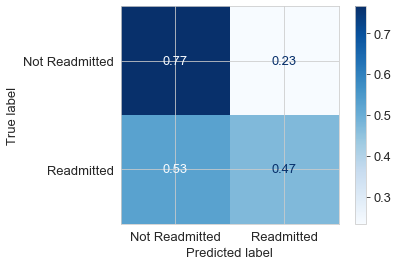

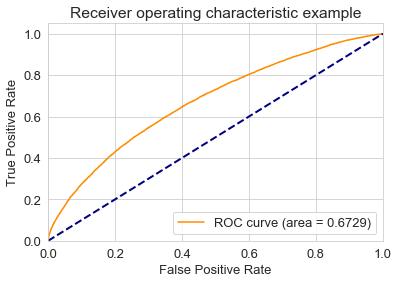

In [16]:
lr = LogisticRegression(max_iter = 5000)

lr.fit(X_train_i,y_train)

#Predicting for testing and trainig data sets
y_test_proba = lr.predict_proba(X_test_i)[:,1]
y_train_proba = lr.predict_proba(X_train_i)[:,1]

y_pred_test = lr.predict(X_test_i)
y_pred_train = lr.predict(X_train_i)

#Accuracy Score
print("Training accuracy: %0.4f" %lr.score(X_train_i, y_train))
print("Test accuracy    : %0.4f" %lr.score(X_test_i, y_test))

#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(lr, X_test_i, y_test,  cmap=plt.cm.Blues, normalize = 'true',display_labels=class_names)
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


Not much change in values for accuracy score for different Interactions

In [17]:
# Pre-processing: Standardization numeric variables
pd.options.mode.chained_assignment = None

transform_col = df_clean2.select_dtypes(exclude = 'object') \
                .drop(['readmitted','gender','change','diabetesMed'], axis = 1).columns

def standardize(train,test, feature_name):
    for col in feature_name:
        mean = train[col].mean()
        sd = train[col].std()
        train[col] = (train[col] - mean)/sd
        test[col] = (test[col] - mean)/sd

    return train, test

X_train_sc, X_test_sc = standardize(X_train_i, X_test_i, transform_col)
#print(X_train[transform_col].describe())


Training accuracy: 0.6291
Test accuracy    : 0.6276
Training AUC Score: 0.6741
Testing AUC Score: 0.6731
Classification Report - Training
              precision    recall  f1-score   support

           0       0.62      0.77      0.69     37271
           1       0.64      0.47      0.54     32806

    accuracy                           0.63     70077
   macro avg       0.63      0.62      0.62     70077
weighted avg       0.63      0.63      0.62     70077

Classification Report - Testing
                precision    recall  f1-score   support

Not Readmitted       0.62      0.76      0.69     15937
    Readmitted       0.64      0.47      0.54     14096

      accuracy                           0.63     30033
     macro avg       0.63      0.62      0.61     30033
  weighted avg       0.63      0.63      0.62     30033



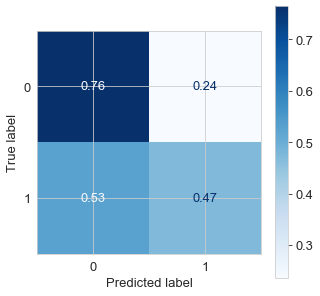

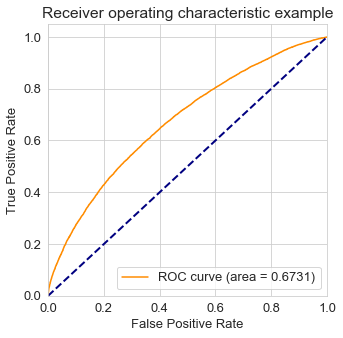

In [18]:
figsize(5,5)
#Building the Logistic Regression Model
lr = LogisticRegression(max_iter = 4000)

lr.fit(X_train_sc,y_train)

#Predicting for testing and trainig data sets
y_test_proba = lr.predict_proba(X_test_sc)[:,1]
y_train_proba = lr.predict_proba(X_train_sc)[:,1]

y_pred_test = lr.predict(X_test_sc)
y_pred_train = lr.predict(X_train_sc)

#Accuracy Score
print("Training accuracy: %0.4f" %lr.score(X_train_sc, y_train))
print("Test accuracy    : %0.4f" %lr.score(X_test_sc, y_test))
#print("Test log loss    : %0.4f" %log_loss(y_train, lr.predict_proba(X_train)))
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(lr, X_test_sc, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)

In [20]:
from sklearn.model_selection import GridSearchCV

#C = [0.01,0.05, 0.1, 0.5]
C = np.logspace(-3,-1,10)
penalty = ['l1', 'l2']
model1 = ['lbfgs', 'liblinear']
param_grid = {'solver': model1, 'C': C}

lr = LogisticRegression(max_iter = 5000)

cv = GridSearchCV(lr,param_grid, cv=5, scoring = 'roc_auc')#, n_jobs = 3)

cv.fit(X_train_sc,y_train)

print(cv.best_params_)
print(cv.best_score_)

{'C': 0.01291549665014884, 'solver': 'liblinear'}
0.6712426474459853


Training accuracy: 0.6292
Test accuracy    : 0.6267
Training AUC Score: 0.6739
Testing AUC Score: 0.6731
Classification Report - Training
              precision    recall  f1-score   support

           0       0.62      0.77      0.69     37271
           1       0.64      0.46      0.54     32806

    accuracy                           0.63     70077
   macro avg       0.63      0.62      0.61     70077
weighted avg       0.63      0.63      0.62     70077

Classification Report - Testing
                precision    recall  f1-score   support

Not Readmitted       0.62      0.77      0.69     15937
    Readmitted       0.64      0.47      0.54     14096

      accuracy                           0.63     30033
     macro avg       0.63      0.62      0.61     30033
  weighted avg       0.63      0.63      0.62     30033



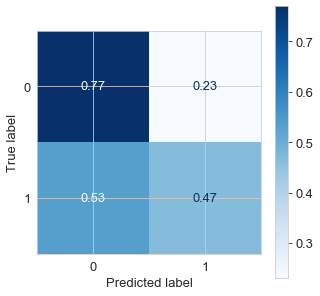

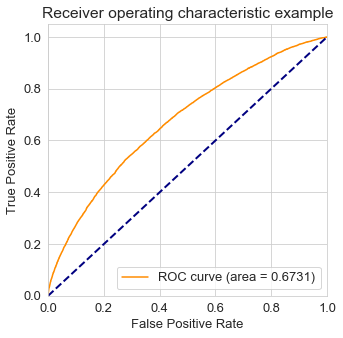

In [21]:
best_lr = cv.best_estimator_

best_lr.fit(X_train_sc,y_train)

#Predicting for testing and trainig data sets
y_test_proba = best_lr.predict_proba(X_test_sc)[:,1]
y_train_proba = best_lr.predict_proba(X_train_sc)[:,1]

y_pred_test = best_lr.predict(X_test_sc)
y_pred_train = best_lr.predict(X_train_sc)

#Accuracy Score
print("Training accuracy: %0.4f" %best_lr.score(X_train_sc, y_train))
print("Test accuracy    : %0.4f" %best_lr.score(X_test_sc, y_test))
#print("Test log loss    : %0.4f" %log_loss(y_train, lr.predict_proba(X_train)))
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(best_lr, X_test_sc, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)
